In [1]:
from scipy.integrate import odeint 
import time
import math
import numpy as np
from math import *
import pickle as pkl
import tensorflow as tf
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
from scipy.optimize import newton
from matplotlib import animation, rc
from matplotlib import pyplot as plt

2024-10-28 21:21:26.284382: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 21:21:26.293797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 21:21:26.305999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 21:21:26.309304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 21:21:26.318045: I tensorflow/core/platform/cpu_feature_guar

In [2]:
m1 = 2                 # mass of pendulum 1 (in kg)
m2 = 1                # mass of pendulum 2 (in kg)
L1 = 1.4                 # length of pendulum 1 (in meter)
L2 = 1               # length of pendulum 2 (in meter)
g = 9.8                # gravitatioanl acceleration constant (m/s^2)

L1 = tf.cast(L1,dtype=tf.float32)
L2 = tf.cast(L2,dtype=tf.float32)
m1 = tf.cast(m1,dtype=tf.float32)
m2 = tf.cast(m2,dtype=tf.float32)
g = tf.cast(g,dtype=tf.float32)

I0000 00:00:1730161287.858832  688723 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730161287.886955  688723 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730161287.963762  688723 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730161287.966054  688723 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
train_window = 40

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L,dim = (input_data).shape
    for i in range(L-tw):
        train_seq = input_data[i:i+tw,:]
        train_label = input_data[i+tw:i+tw+1,:]
        inout_seq.append((train_seq ,train_label))
    return inout_seq


In [4]:
# Differential equations describing the system
def double_pendulum(u,t,m1,m2,L1,L2,g):
    # du = derivatives
    # u = variables
    # p = parameters
    # t = time variable
    
    du = np.zeros(4)
    c = np.cos(u[0]-u[2])  # intermediate variables
    s = np.sin(u[0]-u[2])  # intermediate variables

    du[0] = u[1]   # d(theta 1)
    du[1] = ( m2*g*np.sin(u[2])*c - m2*s*(L1*c*u[1]**2 + L2*u[3]**2) - (m1+m2)*g*np.sin(u[0]) ) /( L1 *(m1+m2*s**2) )
    du[2] = u[3]   # d(theta 2)   
    du[3] = ((m1+m2)*(L1*u[1]**2*s - g*np.sin(u[2]) + g*np.sin(u[0])*c) + m2*L2*u[3]**2*s*c) / (L2 * (m1 + m2*s**2))
    
    return du

def makepath(theta1, theta2,t_final, d_t):
    u0 = [np.pi*theta1/180, 0, np.pi*theta2/180, 0]
    t = np.arange(0, t_final+d_t, d_t)
    sol = odeint(double_pendulum, u0, t, args=(m1,m2,L1,L2,g))
    return sol
    

In [61]:
def gerar_in_out():
    angulo1 = np.random.uniform(-180,180)
    angulo2 = np.random.uniform(-180,180)
    solucao = makepath(angulo1, angulo2,15,0.01) 

    #Scalling manual Z score (x - x_mean)/(x_std)
    mean = np.mean(solucao,axis=(0))
    std = np.std(solucao,axis=(0))

    inputs_normalizados = (solucao-mean)/(std)

    sequencias = create_inout_sequences(inputs_normalizados,train_window) 
    train_inputs = tf.convert_to_tensor([sequencias[i][0] for i in range(len(sequencias))],dtype=tf.float64)
    train_outputs = tf.reshape(tf.convert_to_tensor([sequencias[i][1] for i in range(len(sequencias))],dtype=tf.float64),(-1,4))
    return mean,std,angulo1,angulo2,train_inputs,train_outputs

In [83]:
def prever_e_plotar(posicao,velocidade,mean,std,model_keras,save,filepath):
    t_final = 15
    y0 = [posicao,velocidade]   # Condicoes iniciais: [x0, v0]
    sol2 = makepath(y0[0],y0[1],15,0.01)
    previsoes = ((sol2[:train_window,:]-mean)/std).tolist()
    sol2 = (sol2-mean)/std
    for i in range(t_final*100-train_window+1):
        prev_temp = model_keras((np.array([previsoes[k][:] for k in range(i,train_window+i)]).reshape(-1,train_window,4)),training=False)
        previsoes.append(prev_temp.numpy().tolist()[0])
    previsoes = np.array(previsoes)*std+mean
    sol2 = sol2*std+mean

    plt.figure(figsize=(10,5))
    x = sol2[:,0]
    v =  sol2[:,1]
    x_2 = previsoes[:,0]
    v_2= previsoes[:,1]

    u0 = sol2[:,0]     # theta_1 
    u1 = sol2[:,1]     # omega 1
    u2 = sol2[:,2]     # theta_2 
    u3 = sol2[:,3]     # omega_2 
    x1 = L1*np.sin(u0);          # First Pendulum
    y1 = -L1*np.cos(u0);
    x2 = x1 + L2*np.sin(u2);     # Second Pendulum
    y2 = y1 - L2*np.cos(u2);

    u0_2 = previsoes[:,0]     # theta_1 
    u1_2 = previsoes[:,1]     # omega 1
    u2_2 = previsoes[:,2]     # theta_2 
    u3_2 = previsoes[:,3]     # omega_2 
    x1_2 = L1*np.sin(u0_2);          # First Pendulum
    y1_2 = -L1*np.cos(u0_2);
    x2_2 = x1_2 + L2*np.sin(u2_2);     # Second Pendulum
    y2_2 = y1_2 - L2*np.cos(u2_2);

    n,m = 0,-1
    print(previsoes.shape, sol2.shape)
    plt.plot(x2[n:m], y2[n:m], 'b-', label="Original")
    plt.plot(x2_2[n:m], y2_2[n:m], 'r-',label="Previsão",markersize=1.6)
    print(f"MSE: {(tf.reduce_mean(tf.square(previsoes[train_window:2501]-sol2[train_window:2501])))}")
    print(f"MAE: {(tf.reduce_mean(tf.abs(previsoes[train_window:2501]-sol2[train_window:2501])))}")
    plt.xlabel("Y (m))")
    plt.ylabel("X (m)")
    plt.title("Trajetória da Segunda Massa do Pêndulo Duplo")
    plt.grid(1)
    plt.legend()
    if save:
        plt.savefig(filepath)
    else:
        plt.show()


In [7]:
def decayed_learning_rate(initial_learning_rate,decay_rate,decay_steps,step):
    return initial_learning_rate * decay_rate ** (step / decay_steps)

print(decayed_learning_rate(1e-4,0.70,100,100))


7e-05


In [99]:
#mean,std,angulo1,angulo2,train_inputs,train_outputs = gerar_in_out()


print(f"Média: {mean}, Desvio Padrão: {std}")
print(f"Ângulo 1: {angulo1}, Ângulo 2: {angulo2}")

model_keras = Sequential([
    Input((train_window,4)),
    LSTM(512, return_sequences=True),
    LSTM(256, return_sequences=True),
    LSTM(128,return_sequences=False),
    Dense(4,activation="linear")])

Média: [-0.2237594   0.02987856 -9.69640837 -0.02517155], Desvio Padrão: [ 1.43161462  3.04810515 10.17001608  6.62648642]
Ângulo 1: -151.9340739382119, Ângulo 2: -6.287134965015497


In [107]:
def scaled_mse(x,y):
    return 100*tf.reduce_mean(tf.square(x-y))

def scaled_mae(x,y):
    return 100*tf.reduce_mean(tf.abs(x-y))


model_keras.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-7,amsgrad=0), loss=scaled_mse,metrics=["mae"])
history = model_keras.fit(train_inputs,train_outputs,epochs=2000,batch_size=128, verbose = 2,shuffle=1)

#prever_e_plotar(angulo1,angulo2,mean,std,model_keras,save=False,filepath="")


Epoch 1/2000
12/12 - 1s - 111ms/step - loss: 4.5902e-04 - mae: 0.0015
Epoch 2/2000
12/12 - 0s - 13ms/step - loss: 4.4660e-04 - mae: 0.0015
Epoch 3/2000
12/12 - 0s - 9ms/step - loss: 4.4310e-04 - mae: 0.0015
Epoch 4/2000
12/12 - 0s - 8ms/step - loss: 4.4269e-04 - mae: 0.0015
Epoch 5/2000
12/12 - 0s - 8ms/step - loss: 4.4299e-04 - mae: 0.0015
Epoch 6/2000
12/12 - 0s - 8ms/step - loss: 4.4290e-04 - mae: 0.0015
Epoch 7/2000
12/12 - 0s - 8ms/step - loss: 4.4443e-04 - mae: 0.0015
Epoch 8/2000
12/12 - 0s - 9ms/step - loss: 4.4832e-04 - mae: 0.0015
Epoch 9/2000
12/12 - 0s - 8ms/step - loss: 4.4270e-04 - mae: 0.0015
Epoch 10/2000
12/12 - 0s - 9ms/step - loss: 4.4066e-04 - mae: 0.0015
Epoch 11/2000
12/12 - 0s - 8ms/step - loss: 4.4237e-04 - mae: 0.0015
Epoch 12/2000
12/12 - 0s - 9ms/step - loss: 4.4394e-04 - mae: 0.0015
Epoch 13/2000
12/12 - 0s - 8ms/step - loss: 4.4074e-04 - mae: 0.0015
Epoch 14/2000
12/12 - 0s - 8ms/step - loss: 4.4187e-04 - mae: 0.0015
Epoch 15/2000
12/12 - 0s - 8ms/step - lo

KeyboardInterrupt: 

(1501, 4) (1501, 4)
MSE: 36.695296186201155
MAE: 3.7447306092489514


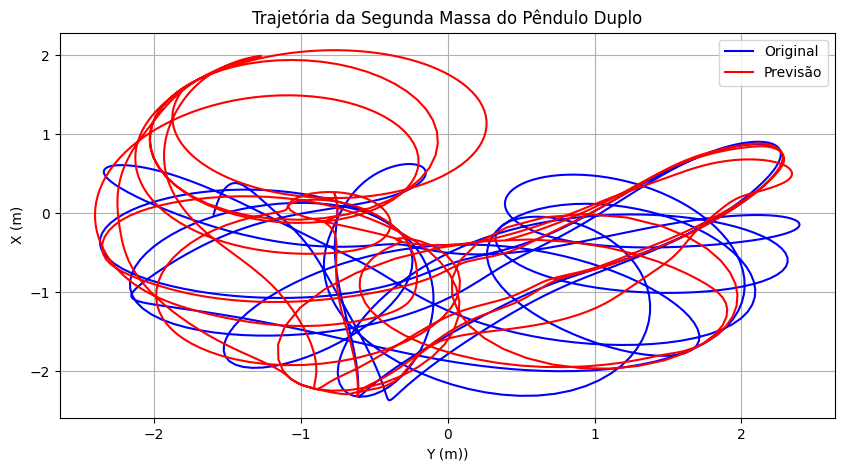

In [108]:
prever_e_plotar(angulo1,angulo2,mean,std,model_keras,save=True,filepath="imagens/Pd5.png")